In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sksurv.nonparametric import kaplan_meier_estimator
from tqdm.notebook import tqdm, trange
from copy import deepcopy
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from lifelines import CoxTimeVaryingFitter

# own imports
from src.utils import create_nfl_field
from src.utils import load_data
from src.utils import life_expectancy

np.set_printoptions(precision=4)
pd.set_option("display.precision", 4)

In [2]:
games, plays, players, scouting, plays_with_collapse, off_cols, def_cols = (
        load_data()
    )
players_with_collapse = pd.merge(
        scouting[scouting.pff_role.isin(["Pass", "Pass Rush", "Pass Block"])][
            ["gameId", "playId", "nflId", "pff_role"]
        ],
        plays_with_collapse,
        how="right",
        on=["gameId", "playId"],
    )


100%|██████████| 8557/8557 [00:01<00:00, 5575.17it/s]


timed_pocketsizes.shape=(8557, 10)


In [3]:

off_team_cols = [
        "possessionTeam_ATL",
        "possessionTeam_BAL",
        "possessionTeam_BUF",
        "possessionTeam_CAR",
        "possessionTeam_CHI",
        "possessionTeam_CIN",
        "possessionTeam_CLE",
        "possessionTeam_DAL",
        "possessionTeam_DEN",
        "possessionTeam_DET",
        "possessionTeam_GB",
        "possessionTeam_HOU",
        "possessionTeam_IND",
        "possessionTeam_JAX",
        "possessionTeam_KC",
        "possessionTeam_LA",
        "possessionTeam_LAC",
        "possessionTeam_LV",
        "possessionTeam_MIA",
        "possessionTeam_MIN",
        "possessionTeam_NE",
        "possessionTeam_NO",
        "possessionTeam_NYG",
        "possessionTeam_NYJ",
        "possessionTeam_PHI",
        "possessionTeam_PIT",
        "possessionTeam_SEA",
        "possessionTeam_SF",
        "possessionTeam_TB",
        "possessionTeam_TEN",
        "possessionTeam_WAS",
    ]

def_team_cols = [
        "defensiveTeam_ATL",
        "defensiveTeam_BAL",
        "defensiveTeam_BUF",
        "defensiveTeam_CAR",
        "defensiveTeam_CHI",
        "defensiveTeam_CIN",
        "defensiveTeam_CLE",
        "defensiveTeam_DAL",
        "defensiveTeam_DEN",
        "defensiveTeam_DET",
        "defensiveTeam_GB",
        "defensiveTeam_HOU",
        "defensiveTeam_IND",
        "defensiveTeam_JAX",
        "defensiveTeam_KC",
        "defensiveTeam_LA",
        "defensiveTeam_LAC",
        "defensiveTeam_LV",
        "defensiveTeam_MIA",
        "defensiveTeam_MIN",
        "defensiveTeam_NE",
        "defensiveTeam_NO",
        "defensiveTeam_NYG",
        "defensiveTeam_NYJ",
        "defensiveTeam_PHI",
        "defensiveTeam_PIT",
        "defensiveTeam_SEA",
        "defensiveTeam_SF",
        "defensiveTeam_TB",
        "defensiveTeam_TEN",
        "defensiveTeam_WAS",
    ]

    ## subset of feature columns
base_feat = [
        "yardsToGo",
        "defendersInBox",
        "Cover-0",
        "Cover-1",
        "Cover-2",
        "Cover-6",
        "misc_def",
        "Quarters",  # cover 4
        "2-Man",  # "cover 5"ish
        "pff_playAction",
        "down2",
        "down3",
        "shotgun",
    ]
opt_feat = ["mean_polydists"] + [f"poly_tau_{i}" for i in range(5, 41, 5)]


In [4]:
norm_cols = list(
        set(base_feat + opt_feat).intersection(
            ["mean_polydists", "defendersInBox", "yardsToGo"]
            + [f"poly_tau_{i}" for i in range(5, 41, 5)]
        )
    )

In [5]:
plays_with_collapse["misc_def"] = plays_with_collapse.pff_passCoverage.isin(
        ["Red Zone", "Bracket", "Prevent", "Miscellaneous"]
    )

In [6]:
X = pd.get_dummies(
        plays_with_collapse[base_feat + opt_feat + ["defensiveTeam", "possessionTeam"]],
        columns=["defensiveTeam", "possessionTeam"],
    )
X[["defensiveTeam", "possessionTeam"]] = plays_with_collapse[
        ["defensiveTeam", "possessionTeam"]
    ]

In [7]:
X.head()

,yardsToGo,defendersInBox,Cover-0,Cover-1,Cover-2,Cover-6,misc_def,Quarters,2-Man,pff_playAction,...,possessionTeam_NYJ,possessionTeam_PHI,possessionTeam_PIT,possessionTeam_SEA,possessionTeam_SF,possessionTeam_TB,possessionTeam_TEN,possessionTeam_WAS,defensiveTeam,possessionTeam
0,2,6.0,False,True,False,False,False,False,False,0,...,False,False,False,False,False,True,False,False,DAL,TB
1,10,6.0,False,False,False,False,False,False,False,0,...,False,False,False,False,False,False,False,False,TB,DAL
2,6,6.0,False,False,False,False,False,False,False,0,...,False,False,False,False,False,False,False,False,TB,DAL
3,10,6.0,False,False,False,False,False,False,False,1,...,False,False,False,False,False,False,False,False,TB,DAL
4,15,7.0,False,False,False,False,False,False,False,0,...,False,False,False,False,False,False,False,False,TB,DAL


In [8]:
# X[norm_cols] = (X[norm_cols] - X[norm_cols].mean()) / X[norm_cols].std()
Y = plays_with_collapse[["survived", "surv_frame", "pass_frame"]]

In [9]:
X["time"] = Y[["surv_frame", "pass_frame"]].min(axis=1)
X["collapse_event"] = (~Y["survived"]) & (Y.surv_frame.lt(Y.pass_frame))
X["pass_event"] = Y.surv_frame.gt(Y.pass_frame)

In [10]:
## at this point, we have a _short_ dataset X,Y
## Now we have to figure out a way of how to build the "correct" full Dataset. 

In [11]:
X.columns

Index(['yardsToGo', 'defendersInBox', 'Cover-0', 'Cover-1', 'Cover-2',
       'Cover-6', 'misc_def', 'Quarters', '2-Man', 'pff_playAction', 'down2',
       'down3', 'shotgun', 'mean_polydists', 'poly_tau_5', 'poly_tau_10',
       'poly_tau_15', 'poly_tau_20', 'poly_tau_25', 'poly_tau_30',
       'poly_tau_35', 'poly_tau_40', 'defensiveTeam_ARI', 'defensiveTeam_ATL',
       'defensiveTeam_BAL', 'defensiveTeam_BUF', 'defensiveTeam_CAR',
       'defensiveTeam_CHI', 'defensiveTeam_CIN', 'defensiveTeam_CLE',
       'defensiveTeam_DAL', 'defensiveTeam_DEN', 'defensiveTeam_DET',
       'defensiveTeam_GB', 'defensiveTeam_HOU', 'defensiveTeam_IND',
       'defensiveTeam_JAX', 'defensiveTeam_KC', 'defensiveTeam_LA',
       'defensiveTeam_LAC', 'defensiveTeam_LV', 'defensiveTeam_MIA',
       'defensiveTeam_MIN', 'defensiveTeam_NE', 'defensiveTeam_NO',
       'defensiveTeam_NYG', 'defensiveTeam_NYJ', 'defensiveTeam_PHI',
       'defensiveTeam_PIT', 'defensiveTeam_SEA', 'defensiveTeam_SF',
       '

In [12]:
X.loc[X.collapse_event == X.pass_event, ['time', 'collapse_event', 'pass_event']]

,time,collapse_event,pass_event
10,24,False,False
28,26,False,False
50,21,False,False
59,34,False,False
99,18,False,False
...,...,...,...
7968,34,False,False
7973,23,False,False
8097,15,False,False
8170,32,False,False


In [13]:
datapoints = []
for idx in trange(len(X)): 
    d = X.iloc[idx].to_dict()
    for ti in range(5, min(d["time"]+5, 41), 5): 
        start = ti-5
        if (ti < 40) and (ti < d["time"]): 
            stop = ti 
        else: 
            stop = d["time"]
        pocket_size = d[f"poly_tau_{ti}"]
        pass_event = d["pass_event"] & ( d["time"] <= stop) 
        collapse_event = d["collapse_event"] & ( d["time"] <= stop) 
        
        dp = deepcopy(d) 
        dp["id"] = idx
        dp["start"] = start
        dp["stop"] = stop
        dp["pocket_size"] = pocket_size
        dp["pass_event"] = pass_event
        dp["collapse_event"] = collapse_event
        datapoints.append(dp)
    

  0%|          | 0/8204 [00:00<?, ?it/s]

In [14]:
tv_cols = ["id", "start", "stop", "pocket_size"]

In [15]:
tvx = pd.DataFrame(datapoints)

In [16]:
X_train, X_test = train_test_split(tvx.id.unique(), test_size=0.2)

In [17]:
tvx.loc[tvx.id.isin(X_train), tv_cols+base_feat+["pass_event", "collapse_event"]].head(10)

,id,start,stop,pocket_size,yardsToGo,defendersInBox,Cover-0,Cover-1,Cover-2,Cover-6,misc_def,Quarters,2-Man,pff_playAction,down2,down3,shotgun,pass_event,collapse_event
0,0,0,5,4.8251,2,6.0,False,True,False,False,False,False,False,0,False,True,True,False,False
1,0,5,10,4.7084,2,6.0,False,True,False,False,False,False,False,0,False,True,True,False,False
2,0,10,15,3.8422,2,6.0,False,True,False,False,False,False,False,0,False,True,True,False,False
3,0,15,20,1.5468,2,6.0,False,True,False,False,False,False,False,0,False,True,True,False,False
4,0,20,25,0.5810,2,6.0,False,True,False,False,False,False,False,0,False,True,True,False,False
5,0,25,29,0.0000,2,6.0,False,True,False,False,False,False,False,0,False,True,True,False,True
6,1,0,5,4.4757,10,6.0,False,False,False,False,False,False,False,0,False,False,False,False,False
7,1,5,10,4.0413,10,6.0,False,False,False,False,False,False,False,0,False,False,False,False,False
8,1,10,15,3.6226,10,6.0,False,False,False,False,False,False,False,0,False,False,False,False,False
9,1,15,20,1.6771,10,6.0,False,False,False,False,False,False,False,0,False,False,False,False,False


In [18]:
pass_ctv = CoxTimeVaryingFitter(penalizer=0.1)
pass_ctv.fit(tvx.loc[tvx.id.isin(X_train), tv_cols+base_feat+["pass_event"]], id_col="id", event_col="pass_event", start_col="start", stop_col="stop", show_progress=True)
pass_ctv.print_summary()

Iteration 1: norm_delta = 1.97e-01, step_size = 0.9500, log_lik = -27611.67989, newton_decrement = 1.49e+02, seconds_since_start = 0.1
Iteration 2: norm_delta = 1.45e-02, step_size = 0.9500, log_lik = -27461.49780, newton_decrement = 8.50e-01, seconds_since_start = 0.2
Iteration 3: norm_delta = 7.74e-04, step_size = 0.9500, log_lik = -27460.64828, newton_decrement = 2.44e-03, seconds_since_start = 0.2
Iteration 4: norm_delta = 4.09e-05, step_size = 1.0000, log_lik = -27460.64584, newton_decrement = 6.15e-06, seconds_since_start = 0.2
Iteration 5: norm_delta = 4.28e-10, step_size = 1.0000, log_lik = -27460.64584, newton_decrement = 7.85e-16, seconds_since_start = 0.3
Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 35668 periods, 6563 subjects, 3513 events>
         event col = 'pass_event'
         penalizer = 0.1
number of subjects = 6563
 number of periods = 35668
  number of events = 3513
partial log-likelihood = -27460.65
  time fit was run = 2026-02-20 08:41:21 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
pocket_size    -0.07      0.93      0.01           -0.09           -0.06                0.92                0.95
yardsToGo      -0.01      0.99      0.00           -0.01           -0.00                0.99                1.00
defendersInBox -0.00      1.00      0.01           -0.03            0.02                0.97                1.03
Cover-0         0.20      1.22      0.08            0.04            0.36                1.04                1.44
Cover-1         0.01      1.01      0.03           -0.04            0.07                0.96                1.07
Cover-2        -0.03      0.97      0.04           -0.10            0.04                0.91                1.04
Cover-6        -0.02      0.98      0.04           -0.10            0.06                0.91                1.06
misc_def       -0.17      0.85      0.06           -0.27           -0.06                0.76                0.95
Quarters        0.02      1.02      0.04           -0.05            0.09                0.95                1.09
2-Man          -0.24      0.79      0.08           -0.39           -0.09                0.68                0.92
pff_playAction -0.34      0.71      0.03           -0.40           -0.29                0.67                0.75
down2           0.06      1.06      0.03            0.01            0.11                1.01                1.12
down3          -0.12      0.89      0.03           -0.17           -0.06                0.84                0.94
shotgun        -0.01      0.99      0.03           -0.06            0.04                0.94                1.04

                cmp to      z      p  -log2(p)
covariate                                     
pocket_size       0.00  -9.19 <0.005     64.50
yardsToGo         0.00  -2.56   0.01      6.58
defendersInBox    0.00  -0.08   0.94      0.10
Cover-0           0.00   2.38   0.02      5.86
Cover-1           0.00   0.42   0.68      0.56
Cover-2           0.00  -0.83   0.41      1.30
Cover-6           0.00  -0.47   0.64      0.65
misc_def          0.00  -2.96 <0.005      8.34
Quarters          0.00   0.49   0.63      0.67
2-Man             0.00  -3.07 <0.005      8.87
pff_playAction    0.00 -11.89 <0.005    105.90
down2             0.00   2.27   0.02      5.44
down3             0.00  -4.28 <0.005     15.70
shotgun           0.00  -0.37   0.71      0.48
---
Partial AIC = 54949.29
log-likelihood ratio test = 302.07 on 14 df
-log2(p) of ll-ratio test = 183.90

<Axes: xlabel='log(HR) (95% CI)'>

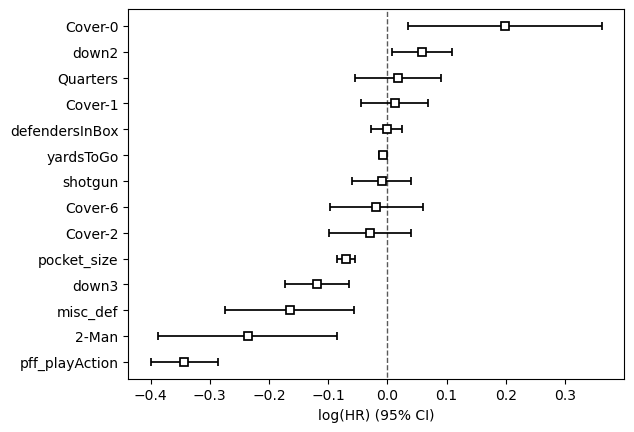

In [19]:
pass_ctv.plot()

In [20]:
X_test

array([7932, 6993, 1214, ..., 6134,  363, 5450], shape=(1641,))

In [21]:
tvx.loc[tvx.id.isin([2486])]

,yardsToGo,defendersInBox,Cover-0,Cover-1,Cover-2,Cover-6,misc_def,Quarters,2-Man,pff_playAction,...,possessionTeam_WAS,defensiveTeam,possessionTeam,time,collapse_event,pass_event,id,start,stop,pocket_size
13413,10,5.0,False,False,True,False,False,False,False,0,...,False,ARI,JAX,24,False,False,2486,0,5,4.7007
13414,10,5.0,False,False,True,False,False,False,False,0,...,False,ARI,JAX,24,False,False,2486,5,10,4.0947
13415,10,5.0,False,False,True,False,False,False,False,0,...,False,ARI,JAX,24,False,False,2486,10,15,3.9046
13416,10,5.0,False,False,True,False,False,False,False,0,...,False,ARI,JAX,24,False,False,2486,15,20,3.6045
13417,10,5.0,False,False,True,False,False,False,False,0,...,False,ARI,JAX,24,True,False,2486,20,24,0.0000


In [22]:
pred = pass_ctv.predict_partial_hazard(tvx.loc[tvx.id.isin([2486]), tv_cols+base_feat+["pass_event"]]).values

In [23]:
pred

array([1.01  , 1.0539, 1.068 , 1.0907, 1.4044])

In [24]:
plot_pred = np.hstack([[pri]*5 for pri in pred])
np.multiply(plot_pred, pass_ctv.baseline_cumulative_hazard_.values[:len(plot_pred), 0])

array([1.6229e-04, 3.2462e-04, 8.1192e-04, 1.1248e-03, 1.5948e-03,
       3.4672e-03, 6.6006e-03, 1.3793e-02, 2.3908e-02, 4.2252e-02,
       7.4355e-02, 1.1122e-01, 1.5496e-01, 1.9580e-01, 2.4050e-01,
       2.9818e-01, 3.6104e-01, 4.3294e-01, 4.9736e-01, 5.8157e-01,
       8.5068e-01, 9.5871e-01, 1.0610e+00, 1.1719e+00, 1.2911e+00])

In [25]:
plot_pred

array([1.01  , 1.01  , 1.01  , 1.01  , 1.01  , 1.0539, 1.0539, 1.0539,
       1.0539, 1.0539, 1.068 , 1.068 , 1.068 , 1.068 , 1.068 , 1.0907,
       1.0907, 1.0907, 1.0907, 1.0907, 1.4044, 1.4044, 1.4044, 1.4044,
       1.4044])

In [26]:
pass_ctv.baseline_cumulative_hazard_.values[:len(plot_pred), 0]

array([1.6068e-04, 3.2141e-04, 8.0388e-04, 1.1137e-03, 1.5790e-03,
       3.2900e-03, 6.2633e-03, 1.3088e-02, 2.2687e-02, 4.0093e-02,
       6.9621e-02, 1.0414e-01, 1.4510e-01, 1.8334e-01, 2.2519e-01,
       2.7338e-01, 3.3102e-01, 3.9694e-01, 4.5600e-01, 5.3321e-01,
       6.0574e-01, 6.8267e-01, 7.5553e-01, 8.3449e-01, 9.1936e-01])

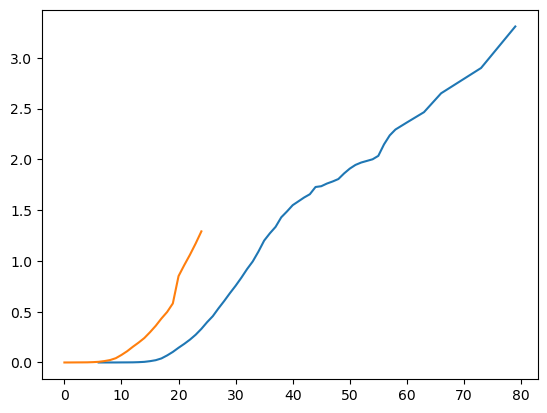

In [27]:
plt.plot(pass_ctv.baseline_cumulative_hazard_, label='baseline_cumulative_hazard')
plt.plot(np.multiply(plot_pred, pass_ctv.baseline_cumulative_hazard_.values[:len(plot_pred), 0]), label="basline*partial")

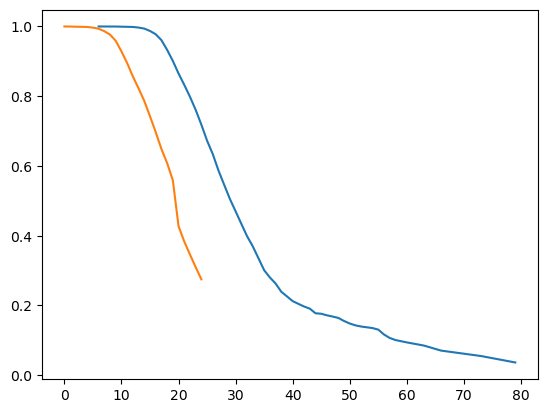

In [28]:
plt.plot(np.exp(-pass_ctv.baseline_cumulative_hazard_), label='baseline_cumulative_survival')
plt.plot(np.exp(-1*np.multiply(plot_pred, pass_ctv.baseline_cumulative_hazard_.values[:len(plot_pred), 0])), label="basline*partial")

In [29]:
collapse_ctv = CoxTimeVaryingFitter(penalizer=0.1)
collapse_ctv.fit(tvx.loc[tvx.id.isin(X_train), tv_cols+base_feat+["collapse_event"]], id_col="id", event_col="collapse_event", start_col="start", stop_col="stop", show_progress=True)
collapse_ctv.print_summary()

Iteration 1: norm_delta = 5.57e-01, step_size = 0.9500, log_lik = -21580.17497, newton_decrement = 9.74e+02, seconds_since_start = 0.0
Iteration 2: norm_delta = 5.95e-02, step_size = 0.9500, log_lik = -20583.63175, newton_decrement = 1.05e+01, seconds_since_start = 0.1
Iteration 3: norm_delta = 3.41e-03, step_size = 0.9500, log_lik = -20573.10090, newton_decrement = 3.43e-02, seconds_since_start = 0.1
Iteration 4: norm_delta = 1.81e-04, step_size = 1.0000, log_lik = -20573.06664, newton_decrement = 8.73e-05, seconds_since_start = 0.2
Iteration 5: norm_delta = 3.90e-09, step_size = 1.0000, log_lik = -20573.06655, newton_decrement = 4.32e-14, seconds_since_start = 0.2
Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 35668 periods, 6563 subjects, 2759 events>
         event col = 'collapse_event'
         penalizer = 0.1
number of subjects = 6563
 number of periods = 35668
  number of events = 2759
partial log-likelihood = -20573.07
  time fit was run = 2026-02-20 08:41:22 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
pocket_size    -0.36      0.70      0.01           -0.38           -0.35                0.69                0.71
yardsToGo      -0.00      1.00      0.00           -0.01            0.00                0.99                1.00
defendersInBox  0.03      1.03      0.01            0.01            0.06                1.01                1.06
Cover-0         0.32      1.38      0.08            0.16            0.48                1.17                1.62
Cover-1         0.02      1.02      0.03           -0.04            0.08                0.96                1.08
Cover-2        -0.05      0.95      0.04           -0.12            0.03                0.89                1.03
Cover-6        -0.05      0.95      0.04           -0.13            0.04                0.88                1.04
misc_def        0.01      1.01      0.06           -0.10            0.13                0.91                1.14
Quarters       -0.04      0.97      0.04           -0.11            0.04                0.89                1.04
2-Man          -0.08      0.92      0.08           -0.24            0.07                0.79                1.08
pff_playAction  0.11      1.11      0.03            0.05            0.16                1.05                1.18
down2           0.00      1.00      0.03           -0.05            0.06                0.95                1.06
down3           0.06      1.06      0.03            0.00            0.12                1.00                1.12
shotgun        -0.06      0.94      0.03           -0.11           -0.01                0.89                0.99

                cmp to      z      p  -log2(p)
covariate                                     
pocket_size       0.00 -43.41 <0.005       inf
yardsToGo         0.00  -1.05   0.29      1.77
defendersInBox    0.00   2.47   0.01      6.21
Cover-0           0.00   3.92 <0.005     13.46
Cover-1           0.00   0.61   0.54      0.88
Cover-2           0.00  -1.24   0.22      2.22
Cover-6           0.00  -1.10   0.27      1.88
misc_def          0.00   0.25   0.80      0.32
Quarters          0.00  -0.89   0.37      1.43
2-Man             0.00  -1.05   0.29      1.76
pff_playAction    0.00   3.57 <0.005     11.46
down2             0.00   0.17   0.86      0.21
down3             0.00   2.04   0.04      4.58
shotgun           0.00  -2.24   0.03      5.31
---
Partial AIC = 41174.13
log-likelihood ratio test = 2014.22 on 14 df
-log2(p) of ll-ratio test = inf

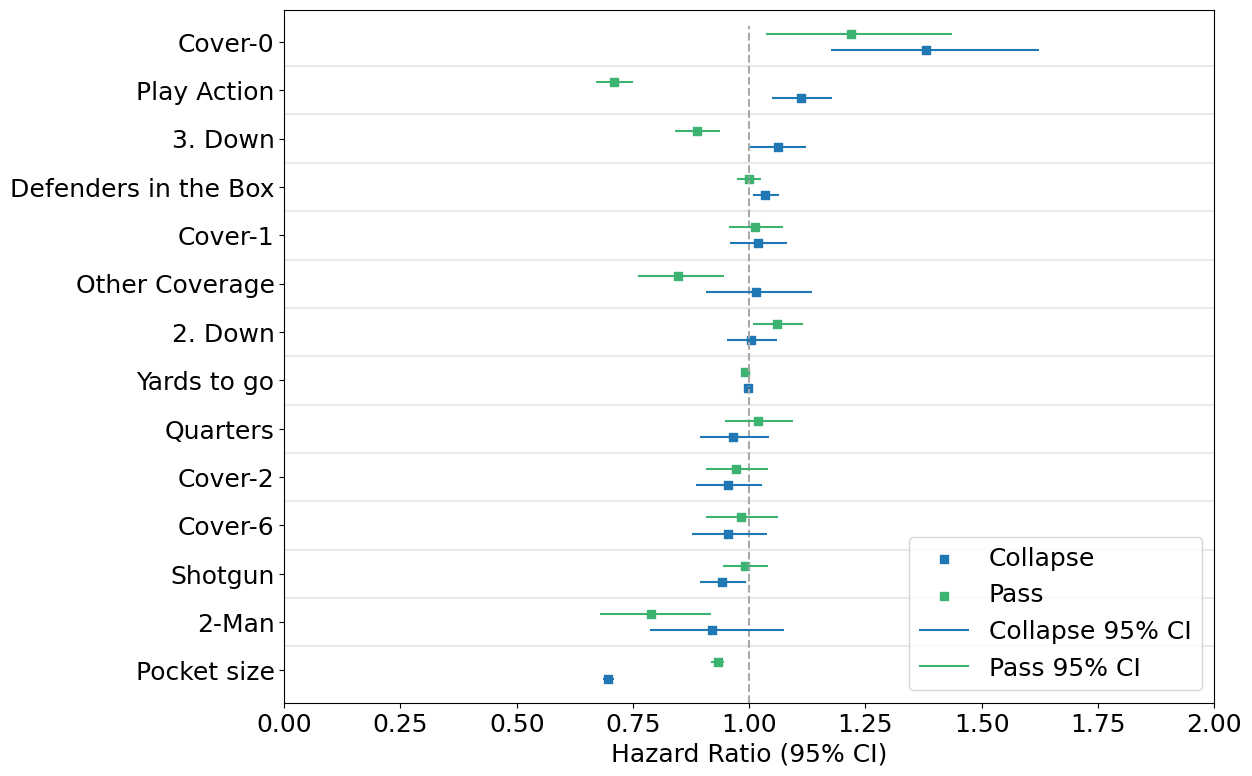

In [30]:
with plt.style.context({"font.size":18}):
    fig, ax = plt.subplots(figsize=(12,9))
    ax.vlines([1.0], ymin=-1, ymax=41, linestyles="--", color="darkgray")
    plt.xlabel("Hazard Ratio (95% CI)")

    yticklabel_dict = {
        "Cover-0":"Cover-0", 
        "Cover-1":"Cover-1", 
        "Cover-2":"Cover-2", 
        "Cover-6":"Cover-6", 
        "Quarters":"Quarters",
        "2-Man":"2-Man",
        "shotgun":"Shotgun", 
        "down3":"3. Down", 
        "down2":"2. Down", 
        "yardsToGo":"Yards to go", 
        "misc_def": "Other Coverage", 
        "pocket_size": "Pocket size", 
        "defendersInBox": "Defenders in the Box", 
        "pff_playAction":"Play Action"
    }

    hr_plot_df = pd.DataFrame({
        "collapse_hr":collapse_ctv.hazard_ratios_,
        "pass_hr":pass_ctv.hazard_ratios_,
        "collapse_lb":np.exp(collapse_ctv.confidence_intervals_["95% lower-bound"]),
        "collapse_ub":np.exp(collapse_ctv.confidence_intervals_["95% upper-bound"]),
        "pass_lb":np.exp(pass_ctv.confidence_intervals_["95% lower-bound"]),
        "pass_ub":np.exp(pass_ctv.confidence_intervals_["95% upper-bound"]),
    }).reset_index().sort_values("collapse_hr")

    y_loc = np.arange(1,43,3)
    hr_plot_df["covariate"] = hr_plot_df["covariate"].map(yticklabel_dict)

    ax.scatter(hr_plot_df["collapse_hr"].values, y_loc-0.5, marker="s", label="Collapse")
    ax.scatter(hr_plot_df["pass_hr"].values, y_loc+0.5, marker="s", color="mediumseagreen", label="Pass")

    ax.hlines(y_loc-0.5, hr_plot_df["collapse_lb"], hr_plot_df["collapse_ub"], label="Collapse 95% CI")
    ax.hlines(y_loc+0.5, hr_plot_df["pass_lb"], hr_plot_df["pass_ub"], label="Pass 95% CI", color="mediumseagreen")
    
    ax.hlines(y_loc[:-1]+1.5, xmin=0.0, xmax=4, color="darkgray", alpha=.25)

    ax.set_yticks(y_loc, hr_plot_df["covariate"].values)
    plt.xlim(0,2)
    plt.ylim(-1,42)
    plt.legend(loc="lower right")
    plt.savefig("time_vary_hr.png", dpi=600)
    plt.show()

## so we now have two models, each of which allows to estimate the hazard conditional on the pocket size
### next step is then to use the hazards to estimate the cumulative incidence conditional on the pocket size
### do we also want to predict / estimate the pocket size pre snap? 

In [31]:
tvx.loc[tvx.id.isin([X_test])]

,yardsToGo,defendersInBox,Cover-0,Cover-1,Cover-2,Cover-6,misc_def,Quarters,2-Man,pff_playAction,...,possessionTeam_WAS,defensiveTeam,possessionTeam,time,collapse_event,pass_event,id,start,stop,pocket_size


In [32]:
collapse_ctv.predict_partial_hazard(tvx.loc[tvx.id.isin(X_test), tv_cols+base_feat+["collapse_event"]])

0       0.5982
1       0.8565
2       1.9441
3       2.9593
4       0.5455
         ...  
8865    1.0356
8866    0.4752
8867    0.5230
8868    0.6565
8869    2.5294
Length: 8870, dtype: float64

In [33]:
hdf = pd.concat([
    pd.Series(np.arange(100), name="t"), 
    collapse_ctv.baseline_survival_.rename(columns={"baseline survival":"baseline_collapse_survival"}), 
    collapse_ctv.baseline_cumulative_hazard_.rename(columns={"baseline hazard":"baseline_collapse_cum_hazard"}),
    pass_ctv.baseline_survival_.rename(columns={"baseline survival":"baseline_pass_survival"}), 
    pass_ctv.baseline_cumulative_hazard_.rename(columns={"baseline hazard":"baseline_pass_cum_hazard"})
    ], axis=1)
hdf['baseline_collapse_survival'] = hdf['baseline_collapse_survival'].ffill().fillna(1.0)
hdf['baseline_collapse_cum_hazard'] = hdf['baseline_collapse_cum_hazard'].ffill().fillna(0.0)

hdf['baseline_pass_survival'] = hdf['baseline_pass_survival'].ffill().fillna(1.0)
hdf['baseline_pass_cum_hazard'] = hdf['baseline_pass_cum_hazard'].ffill().fillna(0.0)

hdf['baseline_collapse_hazard'] = hdf['baseline_collapse_cum_hazard'].diff().fillna(0.0)
hdf['baseline_pass_hazard'] = hdf['baseline_pass_cum_hazard'].diff().fillna(0.0)
hdf.head(15)


,t,baseline_collapse_survival,baseline_collapse_cum_hazard,baseline_pass_survival,baseline_pass_cum_hazard,baseline_collapse_hazard,baseline_pass_hazard
0,0,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000
1,1,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000
2,2,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000
3,3,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000
4,4,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000
5,5,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000
6,6,0.9998,0.0002,0.9998,0.0002,0.0002,0.0002
7,7,0.9998,0.0002,0.9998,0.0002,0.0000,0.0000
8,8,0.9998,0.0002,0.9998,0.0002,0.0000,0.0000
9,9,0.9994,0.0006,0.9997,0.0003,0.0004,0.0002


<Axes: >

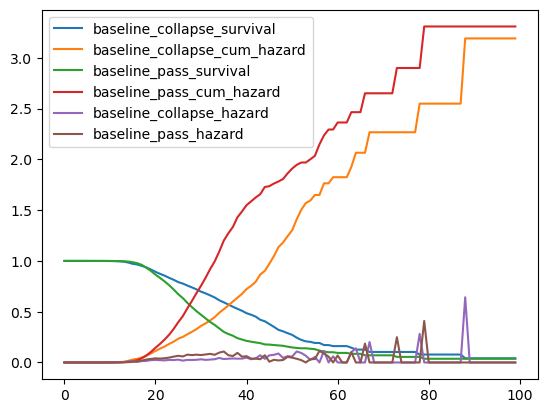

In [35]:
hdf.drop(columns=["t"]).plot()

In [36]:
pass_calib = [[] for _ in range(100)]
total_passes = 0

collapse_calib = [[] for _ in range(100)]
total_collapses = 0

for test_id in tqdm(X_test): 
    input_df = tvx.loc[tvx.id==test_id, tv_cols+base_feat+["collapse_event", "pass_event"]]
    
    pred_partial_hazard_collapse = collapse_ctv.predict_partial_hazard(input_df)
    pred_partial_hazard_collapse.index = input_df.stop

    pred_partial_hazard_pass = collapse_ctv.predict_partial_hazard(input_df)
    pred_partial_hazard_pass.index = input_df.stop

    df = pd.concat([
        hdf["baseline_collapse_hazard"], 
        pred_partial_hazard_collapse.rename("partial_collapse_hazard"),
        hdf["baseline_pass_hazard"], 
        pred_partial_hazard_pass.rename("partial_pass_hazard")
        ],axis=1)

    df["partial_collapse_hazard"] = df["partial_collapse_hazard"].bfill()
    df["collapse_hazard"] = df["partial_collapse_hazard"]*df["baseline_collapse_hazard"]
    df["cum_collapse_hazard"] = df["collapse_hazard"].cumsum()

    df["partial_pass_hazard"] = df["partial_pass_hazard"].bfill()
    df["pass_hazard"] = df["partial_pass_hazard"]*df["baseline_pass_hazard"]
    df["cum_pass_hazard"] = df["pass_hazard"].cumsum()
    
    stop_time = input_df["stop"].max()
    for vh in df.collapse_hazard.head(stop_time).values: 
        collapse_calib[min(int(vh*100), 99)].append(0)
    for vh in df.pass_hazard.head(stop_time).values: 
        pass_calib[min(int(vh*100), 99)].append(0)
    
    chzd = df[["collapse_hazard", "cum_collapse_hazard"]].iloc[stop_time].to_dict()
    phzd = df[["pass_hazard", "cum_pass_hazard"]].iloc[stop_time].to_dict()

    if input_df["collapse_event"].max(): 
        collapse_calib[min(int(chzd["collapse_hazard"]*100), 99)].append(1) 
        total_collapses += 1      

    if input_df["pass_event"].max(): 
        pass_calib[min(int(phzd["pass_hazard"]*100), 99)].append(1)        
        total_passes += 1
    
    # print(stop_time, collapse_happened, pass_happened)
    # print("collapse hazard@stop: ", df[["collapse_hazard", "cum_collapse_hazard"]].iloc[stop_time].to_dict())
    # does this mean, 2.93 % of times this should have collapsed here / 0.0666 percent should have died until this step? 




    # pred_partial_hazard_pass = pass_ctv.predict_partial_hazard(tvx.loc[tvx.id==test_id, tv_cols+base_feat+["pass_event"]])
    # partial hazard is grouped in 5s. 

  0%|          | 0/1641 [00:00<?, ?it/s]

In [37]:
input_df


,id,start,stop,pocket_size,yardsToGo,defendersInBox,Cover-0,Cover-1,Cover-2,Cover-6,misc_def,Quarters,2-Man,pff_playAction,down2,down3,shotgun,collapse_event,pass_event
29622,5450,0,5,4.5697,11,6.0,False,False,False,False,False,True,False,0,True,False,True,False,False
29623,5450,5,10,4.6909,11,6.0,False,False,False,False,False,True,False,0,True,False,True,False,False
29624,5450,10,15,3.6016,11,6.0,False,False,False,False,False,True,False,0,True,False,True,False,False
29625,5450,15,20,0.4416,11,6.0,False,False,False,False,False,True,False,0,True,False,True,False,True


c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mschilling\anaconda3\envs\nfl\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


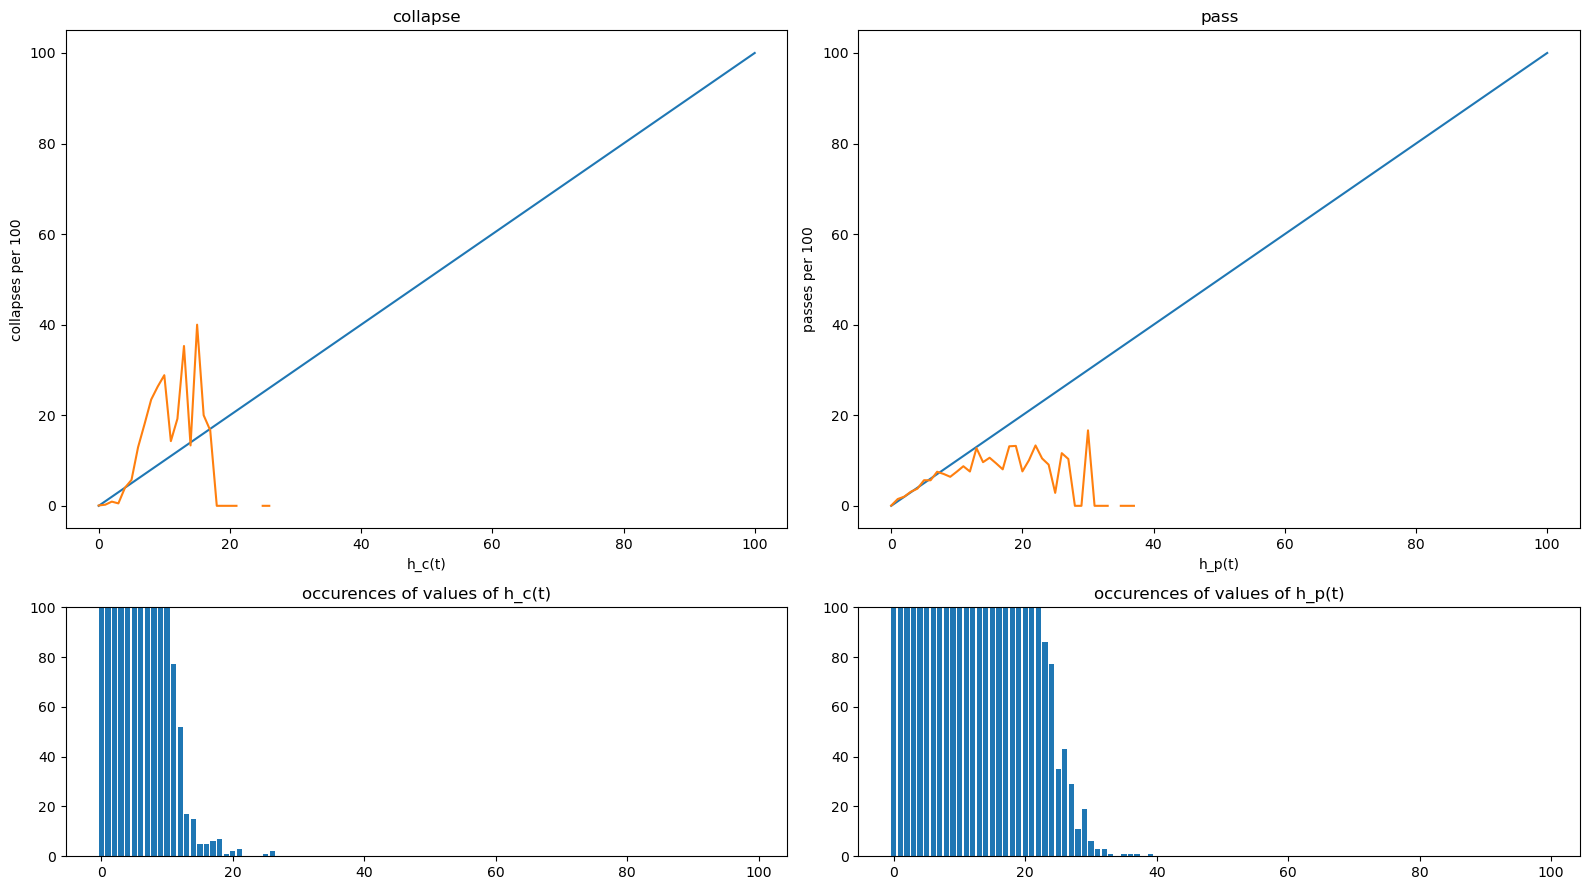

In [38]:
fig, ax = plt.subplots(2,2, figsize=(16,9), height_ratios=(2,1))
ax[0,0].plot([0,100], [0,100])
ax[0,0].plot([np.mean(bucket)*100 for bucket in collapse_calib])
ax[0,0].set_title("collapse")
ax[0,0].set_xlabel("h_c(t)")
ax[0,0].set_ylabel("collapses per 100")
ax[0,1].plot([0,100], [0,100])
ax[0,1].plot([np.mean(bucket)*100 for bucket in pass_calib])
ax[0,1].set_xlabel("h_p(t)")
ax[0,1].set_ylabel("passes per 100")
ax[0,1].set_title("pass")
ax[1,0].bar(np.arange(100), [len(bucket) for bucket in collapse_calib])
ax[1,0].set_title("occurences of values of h_c(t)")
ax[1,1].bar(np.arange(100), [len(bucket) for bucket in pass_calib])
ax[1,1].set_title("occurences of values of h_p(t)")
fig.tight_layout()
ax[1,0].set_ylim(0,100)
ax[1,1].set_ylim(0,100)
plt.show()


<Axes: >

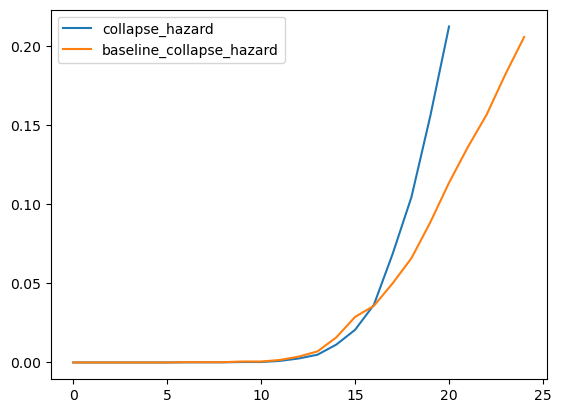

In [39]:
df[["collapse_hazard", "baseline_collapse_hazard"]].cumsum().head(25).plot()

In [107]:
# we have df in 5er buckets. we have collapse event bool, we have event timing. so> how large was hazard before shit hit the fan? 